## Sistema de deteccion y reconocimiento de rostros con el uso de HOG
## Pedro Damian Cruz Santiago. pdcs@atmosfera.unam.mx
## February 2021

In [1]:
%matplotlib inline

from matplotlib import pyplot as plt

import numpy as np
import imutils

In [2]:
def f_imagen_grises(imagen):
    """
    Carga una imagen a partir de la ruta imagen.
    En caso de tratarse de una imagen a color
    imagen.ndim == 3, aplicamos la tranformación https://en.wikipedia.org/wiki/YCbCr
    
    Regresa una tupla con las dimeciones de la imagen y la imagen en escala de grises
    """
    if imagen.ndim == 3:
        imagen_rgb = r, g, b = imagen[:,:,0]*(299/1000), imagen[:,:,1]*(587/1000), imagen[:,:,2]*(114/1000)
        imagen_grises = r+g+b
    else:
        imagen_grises = imagen
    
    return imagen_grises.shape, imagen_grises

def f_ver_imagen_grises(img):
    """
    Función  utilizada para desplegar una imagen que se encuentra en esacala de grises
    """
    plt.imshow(img, cmap=plt.cm.Greys_r)

def f_gradiente_y_x(imagen,dim_yx):
#investigar
#gx[:, :-1] = np.diff(image, n=1, axis=1) 
#gy[:-1, :] = np.diff(image, n=1, axis=0) 
    """
    Recibe una imagen en escala de grises y una tupla con sus dimensiones.
    
    1. El calculo del gradiente para los píxeles en las orillas de la imagen
    consiste considerar ceros un renglo mas allá de las dimensiones de la imagen
    de modo al realiza la diferencial  el resultado es 
    Horizontal: (y,x) = (y,x+1) - (y,0) = (y,x+1)
    Vertical:   (y,x) = (y+1,x) - (0,x) = (y+1,x)

    Horizontal: (y,x) = (y,0) - (y,x) = (y,-x)
    Vertical:   (y,x) = (0,x) - (y,x) = (-y,x)
    
    Regresa la imagen diferencial en la horizontal gx, y en la vertical gy.
    
    """
    gx=np.zeros(dim_yx)
    gy=np.zeros(dim_yx)
    
    gy[0,:]     = imagen[1,:]
    gy[-1,:]     = imagen[-2,:]*-1
    gy[1:-1,:]  = imagen[2:,:]-imagen[0:-2,:]

    gx[:,0]     = imagen[:,1]
    gx[:,-1]     = -imagen[:,-2]*-1
    gx[:,1:-1]  = imagen[:,2:]-imagen[:,0:-2]
    return gy, gx

def f_magnitudes_angulos(gradiente_y, gradiente_x):
    """
    Recibe las imágenes gradiente en la horizontal y vertical.
    
    Se consideran angulos en el rango [-PI/2, PI/2], ángulos negativos
    son cambiados de signo para fines de la construcción del histograma.
    
    Regresa la imagen de magnitudes y la imagen de direcciones o ángulos.

    """
    magnitudes = np.sqrt(gradiente_x**2 + gradiente_y**2)
    angulos = (np.arctan2(gradiente_x, gradiente_y) * (180 / np.pi) ) 
    angulos=np.where(angulos< 0,-angulos,angulos)
    return magnitudes, angulos

def f_clases_angulos_magnitudes(dim_yx,clases_histograma, magnitudes, angulos):
    """
    Recibe la dimencion de las imagenes magnitudes y angulos, el número de clases
    para construir el histograma y las imagenes magnitudes y angulos.
    
    Se generan 2 arreglos de 3 dimensiones, clases_angulos y clases_magnitudes, 
    Se itera sobre las clases del histograma para obtener el rango inferior y superior
    de cada clase, el caso con 9 clases [0,..,8], procesando la clase 0:
    rangoclase_sup = (180 / 9) * (0+1) = 20
    rangoclase_inf = (180 / 9) * (0)   =  0
    
    Con la condidional np.where copiamos en el arreglo clases_angulos aquellos angulos
    en el rango [0,20] de la imagen angulos. 
    
    El arreglo clases_angulos nos servira de filtro para obtener solo aquellos valores de
    la imagen magnitudes cuyos angulos se encuentren en el rango [0,20]
    
    Se regresa los arreglos clases_angulos y clases_magnitudes
    

    """
    
    clases_angulos=np.zeros((dim_yx[0],dim_yx[1],clases_histograma))
    clases_magnitudes=np.zeros((dim_yx[0],dim_yx[1],clases_histograma))
  
    for i in range(clases_histograma):
        rangoclase_sup=(180/clases_histograma)*(i+1)
        rangoclase_inf=(180/clases_histograma)*(i)
        clases_angulos[:,:,i]=np.where(( angulos > rangoclase_inf ) & (angulos<=rangoclase_sup),angulos,0)
        clases_magnitudes[:,:,i]=np.where(clases_angulos[:,:,i]>0,magnitudes,0)
    
    return clases_angulos, clases_magnitudes

def f_histograma_celdas(num_celdas_yx,num_clases,magnitudes):
    """
    Recibe el número de celdas en la vertical y horizontal en la tupla num_celdas_yx, el número de clases y
    el arreglo magnitudes que contiene en cada [:,:,i] con i {0,..,8} las magnitudes correspondientes a cada clase.
    
    Se genera el arreglo histograma_celdas para almacenar el histograma para cada conjunto de 8x8 píxeles
    
        
    *** Por implementar la interpolación bilineal para la asignación de la magnitud en 2 clases
        dependiendo su angulo.
    *** Por implementar la interpolación trilineal para la asginación de la magnitud en las 4 celdas del bloque
    
    """
    histograma_celdas=np.zeros((num_celdas_yx[0],num_celdas_yx[1],num_clases))
    celdax=0
    celday=-1
    for y in range(num_celdas_yx[0]):
        celday += 1
        celdax  = 0
        for x in range(num_celdas_yx[1]):
            for i in range(num_clases):
                t_mag=magnitudes[:,:,i]
                histograma_celdas[celday,celdax,i]=np.sum(t_mag[y:y+8,x:x+8])
            celdax += 1
    return histograma_celdas

def f_histograma_normalizado(histograma,num_celdas_bloque):
    """
    REcibe un arreglo con los histogramas para cada celda: 
    histograma[0,0,:] contiene el histograma de la celda (0,0)
    histograma[0:2,0:2,:] contiene los hisogramas de bloque de 2x2 celdas
    
    Recibe el número de celdas por bloque
    
    Se toman los vectores HOG de 4 celdas y se normalizan almacenandose en el arreglo histograma normalizado.
    
    Se regresa un arreglo que contiene los histogramas normalizados por cada bloque en la imagen,
    
    *** Por implementar, la normalización del vector HOG de toda la imagen, aplicar la ecualización al 0.2 y
        volver a normalizar
    """
    cxp=num_celdas_bloque
    bloquesy=(histograma.shape[0]-cxp)+1
    bloquesx=(histograma.shape[1]-cxp)+1
    histograma_normalizado=np.zeros((bloquesy,bloquesx,cxp,cxp,9))
    
    eps=1e-5
    for bly in range(bloquesy):
        for blx in range(bloquesx):
            norm_1=histograma[bly:bly+cxp,blx:blx+cxp,:]
            norm_2=np.sqrt(np.sum(histograma[bly:bly+cxp,blx:blx+cxp,:] ** 2) + eps ** 2)
            histograma_normalizado[bly,blx,:,:,:]= norm_1 / norm_2
            
    return histograma_normalizado

def f_descriptor_hog(imagen):
    """
    Función principal que recibe una imagen y regresa el vector HOG normalizado
    por bloques.
    
    1. Se obtienen las imagenes gradiente_y y gradiente_x a partir de una imagen
    de entrada y sus dimenciones
    
    2. Se obtienen las imagenes magnitudes y angulos a partir de las imágenes 
    gradiente_y y gradiente_x
    
    3. Se obtiene dos arreglo de 3 dimenciones: (dim_yx[0],dim_yx[1],num_clases). 
    El arreglo clases_magnitudes contiene en [:,:,i] con i en {0,...,8} las magnitudes de los gradientes
    correspondientes a la clase i; 
    [0-20),[20-40),[40-60),[60-80),[80-100),[100-120),[120-140),[140-160),[160-180]
    
    4. Se obtiene un arreglo con los histogramas de cada celda en la imagen, 
    histograma_celdas[0,0,:]  contendrá el histograma de 9 clases para la celda (0,0)
    
    5. Se obtieme un arreglo con el vector HOG de la imagen 
    """
    dim_yx, imagen_grises = f_imagen_grises(imagen)
    num_clases = 9
    pixeles_celda = 8
    num_celdas_yx = (dim_yx[0] // pixeles_celda, dim_yx[1] // pixeles_celda)
    num_celdas_bloque = 2
    
    #1#
    gradiente_y, gradiente_x = f_gradiente_y_x(imagen_grises,dim_yx)
    
    #2#
    magnitudes, angulos = f_magnitudes_angulos(gradiente_y, gradiente_x)
    
    #3#
    clases_angulos, clases_magnitudes = f_clases_angulos_magnitudes(
                                            dim_yx,num_clases, 
                                            magnitudes, angulos)
    #4#
    histograma_celdas= f_histograma_celdas(num_celdas_yx,
                                           num_clases,
                                           clases_magnitudes)
    #5#
    histograma_normalizado=f_histograma_normalizado(histograma_celdas,num_celdas_bloque)

    return histograma_normalizado.ravel()


## Pendientes de implementar

Función "detector" encargada de leer la imagen, invocar a f_piramide y f_ventana_des_y_x para la genración de candidatos.  
Por cada uno de esos candidatos invocar a la función f_descriptor_hog y con el vector resultante invocar a un SVM

In [3]:
def f_piramide(imagen, escala=1.5, minimo=(30,30)):
 
    yield imagen
 
    while True:
        width = int(imagen.shape[1] / escala)
        imagen = imutils.resize(imagen, width=width)
 
        if imagen.shape[0] < minimo[1] or imagen.shape[1] < minimo[0]:
            break
 
        yield imagen
        

def f_ventana_des_y_x(image, step_size, window_size):
    for y in range(0, image.shape[0], step_size):
        for x in range(0, image.shape[1], step_size):
            yield x, y, image[y:y + window_size[1], x:x + window_size[0]]
            

# Construcción de HOG con Scikit-learn


Usando estas características del HOG, podemos construir un algoritmo de detección facial simple con cualquier estimador Scikit-Learn; aquí usaremos una máquina de vectores de soporte lineal. Los pasos son los siguientes:

- Obtener un conjunto de miniaturas de imágenes de caras para constituir muestras de entrenamiento "positivas".
- Obtener un conjunto de miniaturas de imágenes de no caras para constituir muestras de entrenamiento "negativas".
- Extraiga las características del HOG de estos ejemplos de formación.
- Entrene un clasificador SVM lineal en estas muestras.
- Para una imagen "desconocida", pase una ventana deslizante a través de la imagen, utilizando el modelo para evaluar si esa ventana contiene una cara o no.
- Si las detecciones se superponen, combínelas en una sola ventana.
 
 

## The Olivetti faces dataset
This dataset contains a set of face images taken between April 1992 and April 1994 at AT&T Laboratories Cambridge. The sklearn.datasets.fetch_olivetti_faces function is the data fetching / caching function that downloads the data archive from AT&T.

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement).

The image is quantized to 256 grey levels and stored as unsigned 8-bit integers; the loader will convert these to floating point values on the interval [0, 1], which are easier to work with for many algorithms.

The “target” for this database is an integer from 0 to 39 indicating the identity of the person pictured; however, with only 10 examples per class, this relatively small dataset is more interesting from an unsupervised or semi-supervised perspective.

The original dataset consisted of 92 x 112, while the version available here consists of 64x64 images.

|Name|#|
|:-----|:-------|
|Classes|40|
|Samples total|400|
|Dimensionality|64x64 = 4096|
|Features|real, between 0 an 1|

When using these images, please give credit to AT&T Laboratories Cambridge.

In [4]:
from matplotlib import pyplot as plt
import numpy as np

from sklearn import datasets
from sklearn.model_selection import train_test_split
from skimage.feature import hog
#from skimage import data, exposure
from sklearn import metrics
from sklearn import svm

import cv2


## Carga y visualización del conjunto de imágenes olivetti
## incluidos en el framework scikit learn



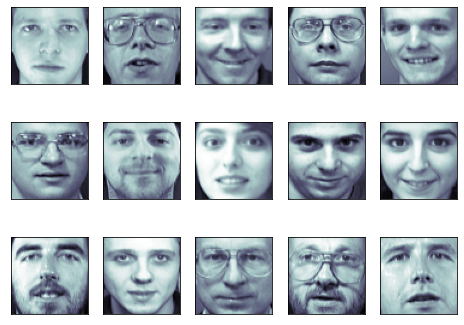

In [5]:
faces = datasets.fetch_olivetti_faces()
fig = plt.figure(figsize=(8, 6))
for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(faces.images[10*i], cmap=plt.cm.bone)

## Creación de los conjuntos de entrenamiento y pruebas

Con **train_test_split** se dividen las imágenes caradas en dos tipos de conjuntos **X_train** y **y_train**  que contiene las imágenes y etiquetas respectivamente, serán utilizadas para entrenar al **SVM** y las clases correspodientes en **X_test**, **y_test**. El parámetro **test_size** indica el pprocentaje de los datos que serán utilizados como grupo de prueba.  

In [84]:
X_train, X_test, y_train, y_test = train_test_split(faces.data,faces.target,random_state=64, train_size=.80)
X_train.shape, X_test.shape

((320, 4096), (80, 4096))

## Extracción de caracteríticas HOG: Scikit-Lear

Usando la biblioteca skimage.feature se extraen los vectores con los descriptores HOG para las imágenes de prueba y entrenamiento

In [ ]:
fd, hog_images_train = hog(X_train, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True)
fd2, hog_images_test = hog(X_test, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True)

## Extracción de caracteríticas HOG: OpenCV


In [7]:
winSize = (32,32)
blockSize = (16,16)
blockStride = (8,8)
cellSize = (8,8)
nbins = 9
derivAperture = 1
winSigma = -1.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
nlevels = 32

In [8]:
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                        histogramNormType,L2HysThreshold,gammaCorrection,nlevels)

In [85]:
X_train=np.uint8(X_train*255)
X_test=np.uint8(X_test*255)
hog_images_train=np.zeros((X_train.shape[0],8100))
hog_images_test=np.zeros((X_test.shape[0],8100))


In [86]:
%%time
for i in range(X_train.shape[0]):
    hog_images_train[i,:]=np.transpose(hog.compute(X_train[i].reshape(64,64)))

for i in range(X_test.shape[0]):
    hog_images_test[i,:]=np.transpose(hog.compute(X_test[i].reshape(64,64)))

CPU times: user 62 ms, sys: 3 ms, total: 65 ms
Wall time: 66.9 ms


## Creación y entrenamiento de la SVM

Se usa **svm.SVC** de sklearn para crear una SVM que se entrena con los vectores **HOG**
de las imágenes de entrenamiento en **hog_images_train** y las clases a las que pertenecen **y_train**

In [108]:
%%time
clf = svm.SVC(kernel='linear', class_weight='balanced') 
clf.fit(hog_images_train, y_train)

CPU times: user 710 ms, sys: 5 ms, total: 715 ms
Wall time: 719 ms


SVC(class_weight='balanced', kernel='linear')

## Pruebas y evaluación

Se toman las  con los vectores **HOG** de las imágenes de prueba **hog_images_test** y se usa svm para predecir a que clases pertenecen **y_pred**. 

Se compararán las clases y_pred con las clases y_test

In [109]:
y_pred = clf.predict(hog_images_test)
print (y_test-y_pred==0)
print("Clasificaciones positivas:",y_test.size - np.count_nonzero(y_pred - y_test ),"de",y_test.size  )

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
 False  True  True False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
Clasificaciones positivas: 78 de 80


In [111]:
#print(metrics.classification_report(y_test, y_pred ))
print("Precision:",metrics.precision_score(y_test, y_pred, average='weighted',zero_division=0 ))
print("Exactitud:",metrics.accuracy_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred, average='weighted',zero_division=0 ))

Precision: 0.99375
Exactitud: 0.975
Recall: 0.975


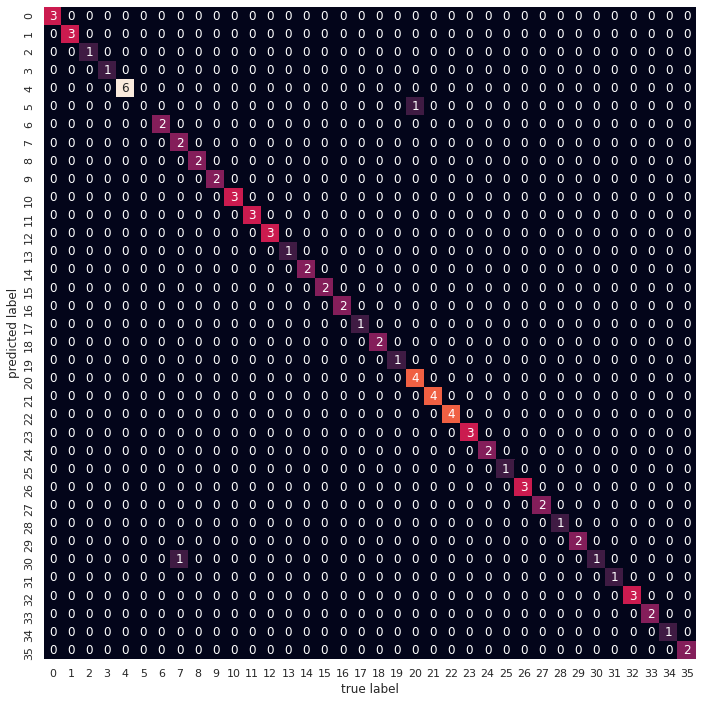

In [112]:
lab=[ f for f in range(40)]
import seaborn as sns; sns.set()
plt.figure(figsize=(12, 12))
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

